In [ ]:
!pip install -q datasets tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12

In [ ]:
!pip install datasets
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from datasets import load_dataset

# (Rest of your code remains unchanged)

# Load SNLI dataset
snli = load_dataset("snli")

# Debug: Print unique labels
print("Unique labels in SNLI dataset:", set(snli['train']['label']))

# Filter valid labels (0: entailment, 1: contradiction, 2: neutral, -1 is invalid)
valid_labels = {0: "entailment", 1: "contradiction", 2: "neutral"}

filtered_data = [
    (p, h, l) for p, h, l in zip(snli['train']['premise'], snli['train']['hypothesis'], snli['train']['label'])
    if l in valid_labels and p is not None and h is not None
]

# Ensure valid data exists
if not filtered_data:
    raise ValueError("❌ No valid data found! Check if dataset is correctly loaded.")

# Unzip data
premises, hypotheses, labels = zip(*filtered_data)

# Tokenize and preprocess data
def preprocess_texts(premises, hypotheses, vocab_size=10000, max_len=50):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(premises + hypotheses)

    premise_seq = tokenizer.texts_to_sequences(premises)
    hypothesis_seq = tokenizer.texts_to_sequences(hypotheses)

    premise_padded = pad_sequences(premise_seq, maxlen=max_len, padding='post')
    hypothesis_padded = pad_sequences(hypothesis_seq, maxlen=max_len, padding='post')

    return premise_padded, hypothesis_padded, tokenizer

# Preprocess data
premise_padded, hypothesis_padded, tokenizer = preprocess_texts(list(premises), list(hypotheses))

# Combine premise and hypothesis as input features
X = np.concatenate((premise_padded, hypothesis_padded), axis=1)
y = np.array(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train LSTM model
def build_lstm_model(vocab_size, embedding_dim=100, max_len=50):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax')) # 3 classes: entailment, contradiction, neutral


    model.build(input_shape=(None,max_len * 2))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

vocab_size = 10000
model = build_lstm_model(vocab_size)
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32, steps_per_epoch=500)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy * 100:.2f}%")

# 🔹 **User Input Prediction Function**
def predict_snli(model, tokenizer, premise, hypothesis, max_len=50):
    premise_seq = tokenizer.texts_to_sequences([premise])
    hypothesis_seq = tokenizer.texts_to_sequences([hypothesis])

    premise_padded = pad_sequences(premise_seq, maxlen=max_len, padding='post')
    hypothesis_padded = pad_sequences(hypothesis_seq, maxlen=max_len, padding='post')

    X_input = np.concatenate((premise_padded, hypothesis_padded), axis=1)

    prediction = model.predict(X_input)
    predicted_label = np.argmax(prediction, axis=1)[0]

    label_map = {0: "Entailment", 1: "Contradiction", 2: "Neutral"}

    print("\n💡 **Prediction Result** 💡")
    print(f"📝 Premise: {premise}")
    print(f"📝 Hypothesis: {hypothesis}")
    print(f"✅ Prediction: {label_map[predicted_label]} (Confidence: {max(prediction[0]) * 100:.2f}%)")

# 🔹 **User Input**
user_premise = input("Enter a premise sentence: ")
user_hypothesis = input("Enter a hypothesis sentence: ")

predict_snli(model, tokenizer, user_premise, user_hypothesis)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/413k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Unique labels in SNLI dataset: {0, 1, 2, -1}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,171,011 (4.47 MB)

 Trainable params: 1,171,011 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 380s 753ms/step - accuracy: 0.3327 - loss: 1.1001 - val_accuracy: 0.3338 - val_loss: 1.0986
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 375s 751ms/step - accuracy: 0.3373 - loss: 1.0991 - val_accuracy: 0.3313 - val_loss: 1.0999
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 373s 747ms/step - accuracy: 0.3329 - loss: 1.0992 - val_accuracy: 0.3313 - val_loss: 1.1003
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 249s 72ms/step - accuracy: 0.3328 - loss: 1.1001
LSTM Model Accuracy: 33.13%
Enter a premise sentence: All dogs are mammals.
Enter a hypothesis sentence: If a dog is fed a certain type of food, it will gain weight.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step

💡 **Prediction Result** 💡
📝 Premise: All dogs are mammals.
📝 Hypothesis: If a dog is fed a certain type of food, it will gain weight.
✅ Prediction: Neutral (Confidence: 35.80%)


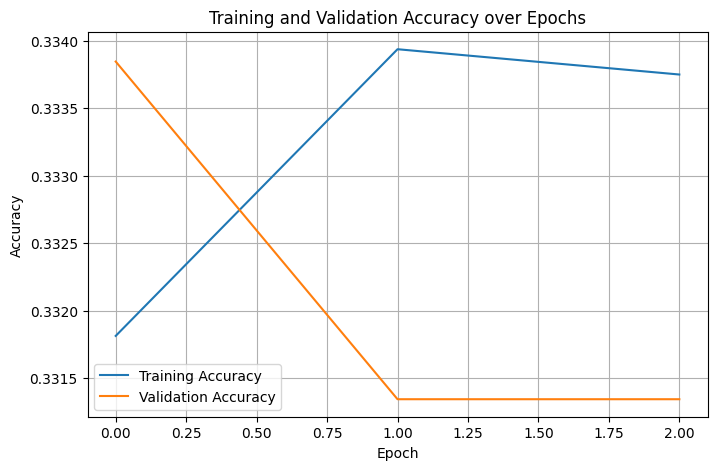

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Display a few examples from SNLI dataset
print("\n📄 Sample SNLI Data:")
for i in range(5):  # display 5 examples
    print(f"\nExample {i+1}:")
    print(f"Premise: {snli['train']['premise'][i]}")
    print(f"Hypothesis: {snli['train']['hypothesis'][i]}")
    print(f"Label: {snli['train']['label'][i]}")



📄 Sample SNLI Data:

Example 1:
Premise: A person on a horse jumps over a broken down airplane.
Hypothesis: A person is training his horse for a competition.
Label: 1

Example 2:
Premise: A person on a horse jumps over a broken down airplane.
Hypothesis: A person is at a diner, ordering an omelette.
Label: 2

Example 3:
Premise: A person on a horse jumps over a broken down airplane.
Hypothesis: A person is outdoors, on a horse.
Label: 0

Example 4:
Premise: Children smiling and waving at camera
Hypothesis: They are smiling at their parents
Label: 1

Example 5:
Premise: Children smiling and waving at camera
Hypothesis: There are children present
Label: 0
